In [2]:
import os
import pickle
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
# load features from pickle
with open(os.path.join('D:\SEM-6\DL-LAB\DL_PROJ', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [46]:
len(features['1001773457_577c3a7d70'][0])

4096

In [4]:
with open(os.path.join('D:\SEM-6\DL-LAB\DL_PROJ\Flickr_Dataset', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [5]:

mapping = {}
for line in captions_doc.split('\n'):

    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [39]:
mapping

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [6]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
clean(mapping)

In [9]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
print(len(all_captions))
all_captions[:10]

40455


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [12]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [47]:
vocab_size

8485

In [13]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
import random
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    random.shuffle(data_keys)

    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

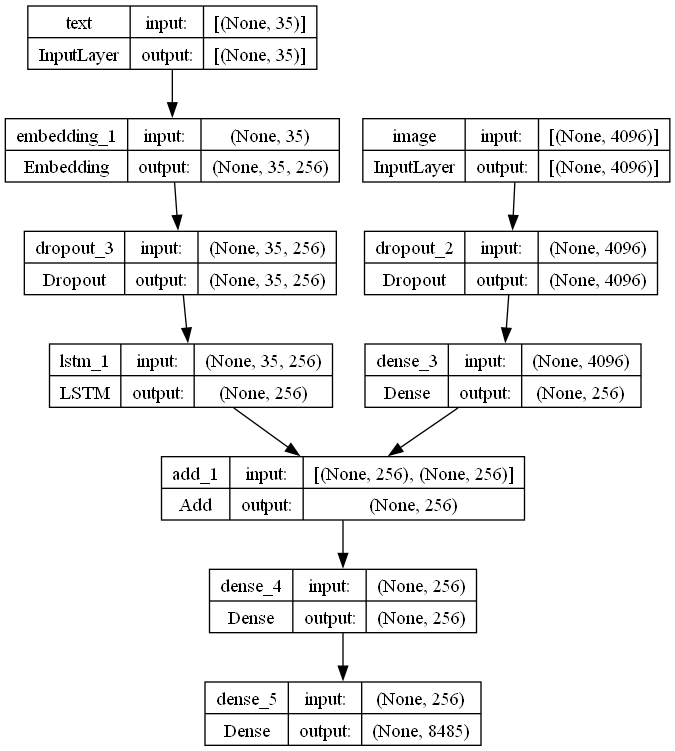

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# plot the model
plot_model(model, show_shapes=True)

In [26]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


In [27]:
import matplotlib.pyplot as plt

# Set training parameters
epochs = 20
batch_size = 32
steps = len(train) // batch_size  # Calculate steps per epoch

losses = []
accuracies = []

# Training loop
for i in range(epochs):
    # Create data generator for the current epoch
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit the model for one epoch using the data generator
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard_callback])
    
    # Append loss and accuracy from history to respective lists
    losses.append(history.history['loss'])
    accuracies.append(history.history['accuracy'])


202/202 [==============================] - 446s 2s/step - loss: 2.0023 - accuracy: 0.4769


In [30]:
model.save('captionModel.h5')

c:\Users\MAAL SUBIKSHA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


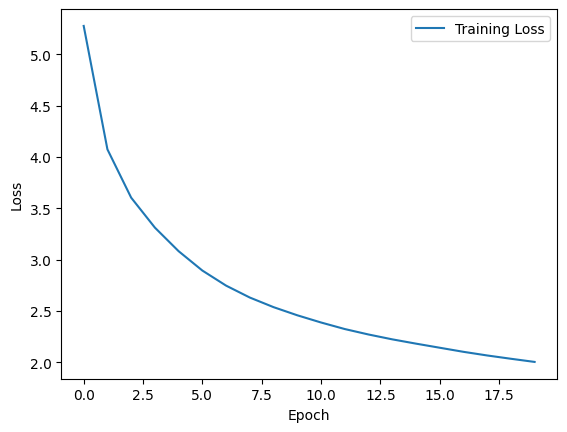

In [28]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


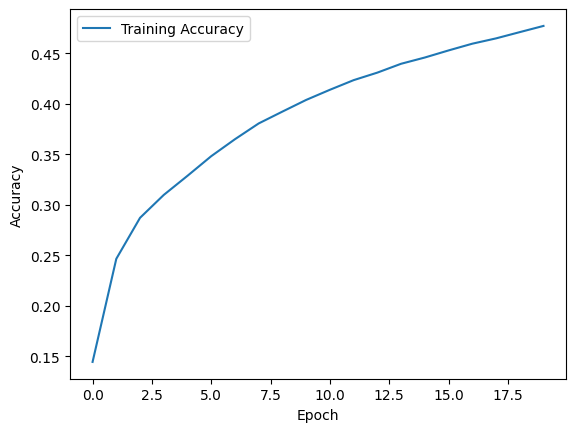

In [29]:

# Plot training accuracy
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [50]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

: 

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("D:\SEM-6\DL-LAB\DL_PROJ\Flickr_Dataset", "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------------Predicted--------------------
startseq boston terrier is running through the grass endseq


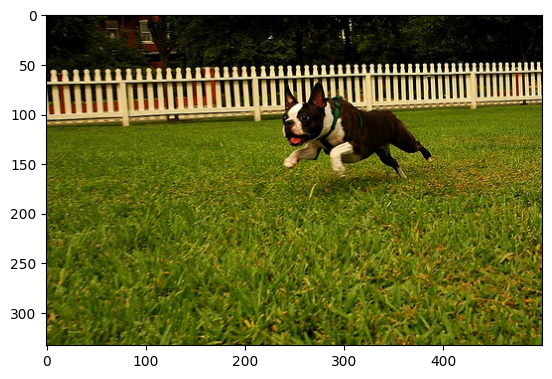

In [49]:
generate_caption('1009434119_febe49276a.jpg')